In [1]:
import re
import zarr
import glob
import torch
import pickle

import numpy as np
import matplotlib.pyplot as plt

from rich import print
from scipy import stats
from sortedcontainers import SortedKeyList
from alive_progress import alive_it
from omegaconf import OmegaConf
from pathlib import Path
from scipy.ndimage import zoom
from dataclasses import dataclass, fields
from matplotlib.colors import LinearSegmentedColormap

from walrus_workshop.model import load_sae
from walrus_workshop.walrus import get_trajectory
from walrus_workshop.metrics import compute_okubo_weiss
from walrus_workshop.utils import get_key_value_from_string

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using device: cuda


In [2]:
# Load the config
cfg = OmegaConf.load("configs/train.yaml")

# Load the trajectory
trajectory_id = 50
trajectory, trajectory_metadata = get_trajectory(cfg.walrus.dataset, trajectory_id)

# Load file list of the activations
activations_dir = (
    Path("activations")
    / "test"
    / "blocks.20.space_mixing.activation"
    / cfg.walrus.dataset
)
act_files = sorted(glob.glob(str(activations_dir / f"*_traj_{trajectory_id}*")))
# List of steps with activations (starting step)
steps = np.array([int(get_key_value_from_string(file_name, "step")) for file_name in act_files])

# Load the trained SAE
checkpoint_path = (
    Path("checkpoints")
    / "sae_checkpoint_blocks.20.space_mixing.activation_source_test_k_active=32_k_aux=2048_latent=22528_beta=0.1.pt"
)
sae_model, sae_config = load_sae(checkpoint_path)
sae_model = sae_model.to(device).eval()

In [3]:
step_index = 1
step = steps[step_index]
print(f"Step: {step}")

Step: 5

In [28]:
@dataclass
class DataChunk:
    step: int
    n_features: int
    n_timesteps: int
    simulation: np.ndarray
    tokens: np.ndarray
    code: np.ndarray
    target: np.ndarray


def get_data_chunk(step, step_index, act_files, trajectory, cfg, sae_model, device, verbose=False):

    # Get SAE features
    if verbose:
        print(f"Opening activation file {Path(act_files[step_index]).stem}")
    assert get_key_value_from_string(Path(act_files[step_index]).stem, "step") == step # make sure we are processing the same step
    act = zarr.open(act_files[step_index], mode="r")
    act = torch.from_numpy(np.array(act)).to(device)
    with torch.no_grad():
        _, code, _ = sae_model(act)
    code = code.cpu().numpy()

    # Get simulation chunk
    simulation_chunk = trajectory['input_fields'][0, step:step+cfg.walrus.n_steps_input+1, :, :, 0, :]
    if verbose:
        print(f"Simulation chunk shape: {simulation_chunk.shape}")

    scale_x = int(simulation_chunk.shape[2] / 32)  # width
    scale_y = int(simulation_chunk.shape[1] / 32)  # height

    Q_sign = np.zeros((simulation_chunk.shape[0], 32, 32)) # 32 x 32 
    tokens = np.zeros((simulation_chunk.shape[0], 32, 32, simulation_chunk.shape[-1]))
    for i in range(simulation_chunk.shape[0]):
        for ix in range(32):
            for iy in range(32):
                token = simulation_chunk[i, iy*scale_y:(iy+1)*scale_y, ix*scale_x:scale_x*(ix+1), :]
                tokens[i, iy, ix] = token.mean(axis=[0,1])
                Q_sign[i, iy, ix] = np.sign(compute_okubo_weiss(token[:, :, 2], token[:, :, 3])[0].mean())

    data_chunk = DataChunk(step=step, n_features=code.shape[1], n_timesteps=simulation_chunk.shape[0]-1, simulation=simulation_chunk[:-1], tokens=tokens, code=code, target=Q_sign[:-1])
    return data_chunk

Opening activation file step_0005_traj_50_Reynolds_1e+05_Schmidt_5e-01_layerblocks.20.space_mixing.activation

Simulation chunk shape: torch.Size([7, 256, 512, 5])

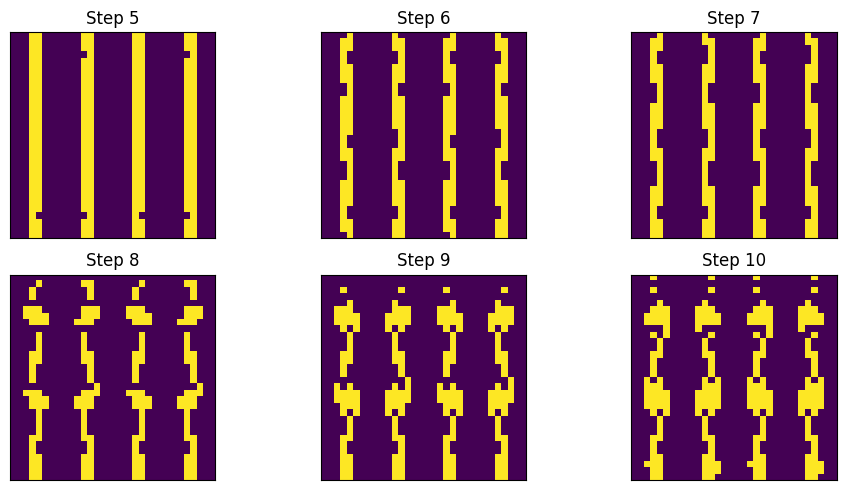

In [29]:
step_index = 1
step = steps[step_index]
data_chunk = get_data_chunk(step=step, step_index=step_index, act_files=act_files, trajectory=trajectory, cfg=cfg, sae_model=sae_model, device=device, verbose=True)
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
for i in range(data_chunk.target.shape[0]):
    ax = axs[i // 3, i % 3]
    ax.imshow(data_chunk.target[i])
    ax.set_title(f"Step {data_chunk.step + i}")
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

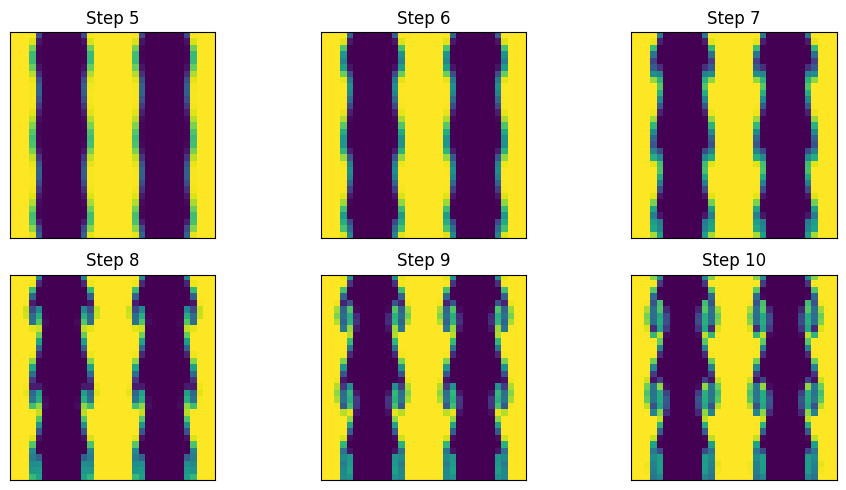

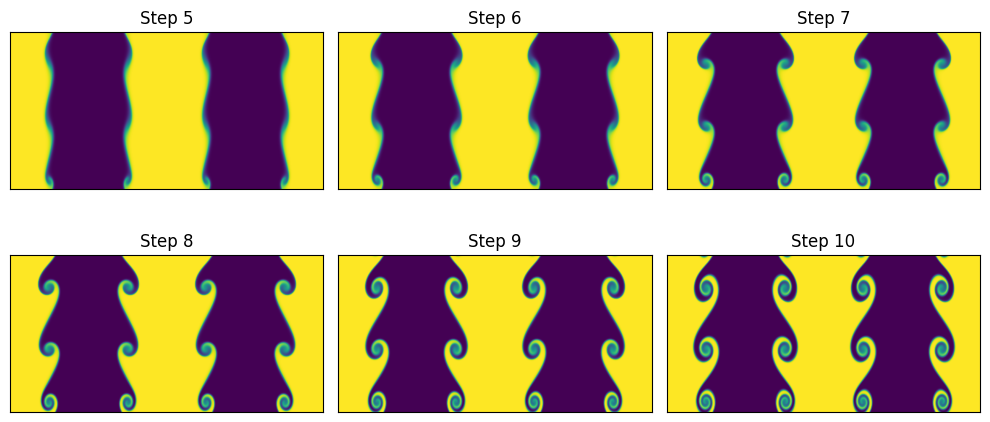

In [32]:

fig, axs = plt.subplots(2, 3, figsize=(10, 5))
for i in range(data_chunk.target.shape[0]):
    ax = axs[i // 3, i % 3]
    ax.imshow(data_chunk.tokens[i, ..., 0])
    ax.set_title(f"Step {data_chunk.step + i}")
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()


fig, axs = plt.subplots(2, 3, figsize=(10, 5))
for i in range(data_chunk.target.shape[0]):
    ax = axs[i // 3, i % 3]
    ax.imshow(data_chunk.simulation[i, ..., 0])
    ax.set_title(f"Step {data_chunk.step + i}")
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()



Opening activation file step_0100_traj_50_Reynolds_1e+05_Schmidt_5e-01_layerblocks.20.space_mixing.activation

Simulation chunk shape: torch.Size([7, 256, 512, 5])

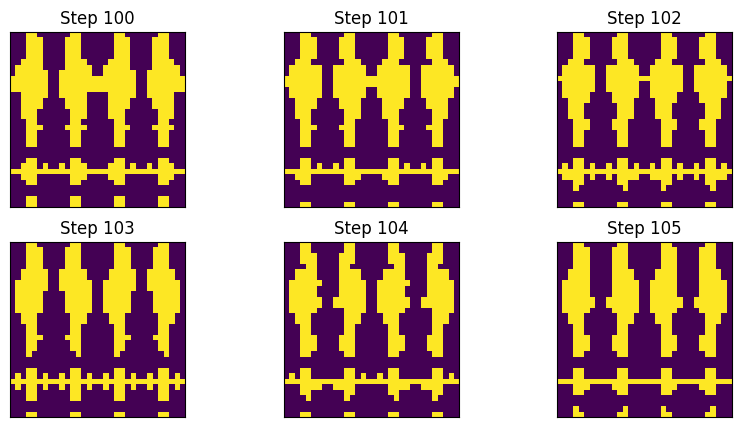

In [16]:
step_index = len(steps) - 1 
step = steps[step_index]
data_chunk = get_data_chunk(step=step, step_index=step_index, act_files=act_files, trajectory=trajectory, cfg=cfg, sae_model=sae_model, device=device, verbose=True)
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
for i in range(data_chunk.target.shape[0]):
    ax = axs[i // 3, i % 3]
    ax.imshow(data_chunk.target[i])
    ax.set_title(f"Step {data_chunk.step + i}")
    ax.set_xticks([]); ax.set_yticks([])
plt.show()
fig.tight_layout()

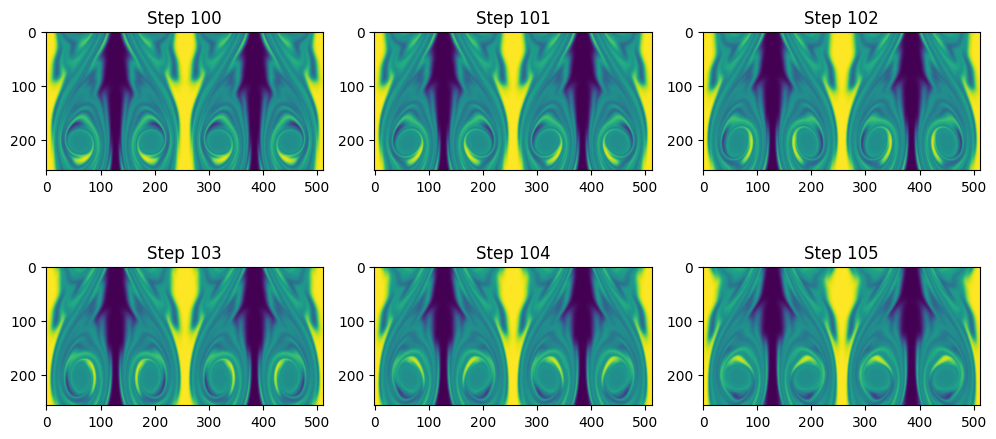

In [18]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5))
for i in range(data_chunk.target.shape[0]):
    ax = axs[i // 3, i % 3]
    ax.imshow(data_chunk.simulation[i, ..., 0])
    ax.set_title(f"Step {data_chunk.step + i}")
    # ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()
